In [1]:
import tensorflow as tf
import time
from datetime import timedelta
import numpy as np
import os
ks=tf.keras
print(tf.config.list_physical_devices('GPU'))

2023-04-06 09:02:58.049530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/run/ge2011.11/lib/linux-x64
2023-04-06 09:02:58.049560: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-06 09:02:58.923934: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/run/ge2011.11/lib/linux-x64
2023-04-06 09:02:58.924030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No suc

[]


2023-04-06 09:03:00.008094: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/run/ge2011.11/lib/linux-x64
2023-04-06 09:03:00.008119: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-06 09:03:00.008144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tcbserver2): /proc/driver/nvidia/version does not exist


## 1. Data


In [2]:
from kgcnn.graph.base import GraphDict
from kgcnn.data.base import MemoryGraphList, MemoryGraphDataset
from kgcnn.data.qm import QMDataset
from kgcnn.training.scheduler import LinearLearningRateScheduler

data_directory="data/B3LYP_def2-TZVPP_water/"
file_name="ThiolDisulfidExchange.csv"
dataset_name="ThiolDisulfidExchange"

In [3]:
dataset = QMDataset(data_directory=data_directory, file_name=file_name, dataset_name=dataset_name)

In [4]:
dataset.prepare_data(overwrite=True, make_sdf = True);

INFO:kgcnn.data.ThiolDisulfidExchange:Converting xyz to mol information.


In [5]:
dataset.read_in_memory(label_column_name="energy", additional_callbacks = {'total_charge': lambda mg, dd: dd['total_charge']});

INFO:kgcnn.data.ThiolDisulfidExchange:Reading structures from SDF file.
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 0 from 5112
INFO:kgcnn.data.ThiolDisulfidExchange: ... process molecules 5000 from 5112


In [6]:
dataset.map_list(method="set_range", max_distance=5.0);
dataset.map_list(method="set_angle");

In [7]:
esp_path = os.path.join(os.path.normpath(os.path.dirname(dataset.file_path)), "esps_by_mm.txt")
esps = np.loadtxt(esp_path)
for i in range(len(dataset)):
    dataset[i].set("esp", esps[i])

In [9]:
dataset.save();

INFO:kgcnn.data.ThiolDisulfidExchange:Pickle dataset...


In [10]:
dataset = MemoryGraphDataset(data_directory=data_directory, dataset_name=dataset_name)
dataset.load();
print(dataset[0].keys())

INFO:kgcnn.data.ThiolDisulfidExchange:Load pickled dataset...


dict_keys(['node_symbol', 'node_number', 'node_coordinates', 'edge_indices', 'edge_number', 'total_charge', 'graph_labels', 'range_indices', 'range_attributes', 'angle_indices', 'angle_indices_nodes', 'angle_attributes', 'esp'])


## 2. Model

In [11]:
from kgcnn.literature.HDNNP4th import make_model_behler as make_model

In [12]:
model_config = {
    "name": "HDNNP4th",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True},
               {"shape": (1,), "name": "total_charge", "dtype": "float32", "ragged": False},
               {"shape": (None,), "name": "esp", "dtype": "float32", "ragged": True}],
    "g2_kwargs": {"eta": [0.0, 0.3], "rs": [0.0, 3.0], "rc": 10.0, "elements": [1, 6, 16]},
    "g4_kwargs": {"eta": [0.0, 0.3], "lamda": [-1.0, 1.0], "rc": 6.0,
                  "zeta": [1.0, 8.0], "elements": [1, 6, 16], "multiplicity": 2.0},
    "normalize_kwargs": {},
    "mlp_charge_kwargs": {"units": [64, 64, 1],
                          "num_relations": 96,
                          "activation": ["swish", "swish", "linear"]},
    "mlp_local_kwargs": {"units": [64, 64, 1],
                         "num_relations": 96,
                         "activation": ["swish", "swish", "linear"]},
    "cent_kwargs": {},
    "electrostatic_kwargs": {"name": "electrostatic_layer"},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}

In [16]:
model = make_model(**model_config);

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'HDNNP4th', 'inputs': [{'shape': (None,), 'name': 'node_number', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'node_coordinates', 'dtype': 'float32', 'ragged': True}, {'shape': (None, 2), 'name': 'edge_indices', 'dtype': 'int64', 'ragged': True}, {'shape': (None, 3), 'name': 'angle_indices_nodes', 'dtype': 'int64', 'ragged': True}, {'shape': (1,), 'name': 'total_charge', 'dtype': 'float32', 'ragged': False}], 'g2_kwargs': {'eta': [0.0, 0.3], 'rs': [0.0, 3.0], 'rc': 10.0, 'elements': [1, 6, 16]}, 'g4_kwargs': {'eta': [0.0, 0.3], 'lamda': [-1.0, 1.0], 'rc': 6.0, 'zeta': [1.0, 8.0], 'elements': [1, 6, 16], 'multiplicity': 2.0}, 'normalize_kwargs': {}, 'mlp_charge_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'mlp_local_kwargs': {'units': [64, 64, 1], 'num_relations': 96, 'activation': ['swish', 'swish', 'linear']}, 'cent_kwargs': {}, 'electros

In [22]:
elemental_mapping = [1,6,16]

# Radial parameters
cutoff_rad = 10
Rs_array   = [0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
eta_array  = [0.0, 0.03, 0.08, 0.16, 0.3, 0.5]

# Angular parameters
cutoff_ang    = 6
lambd_array   = [-1, 1]
zeta_array    = [1, 2, 4, 8, 16]
eta_ang_array = eta_array

In [23]:
from kgcnn.literature.HDNNP4th import make_model_rep

rep_model_configs = {
    "name": "HDNNP2nd",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True}],
    "g2_kwargs": {"eta": eta_array, "rs": Rs_array, "rc": cutoff_rad, "elements": elemental_mapping},
    "g4_kwargs": {"eta": eta_ang_array, "zeta": zeta_array, "lamda": lambd_array, "rc": cutoff_ang, "elements": elemental_mapping}
}
rep_model = make_model_rep(**rep_model_configs)
rep = rep_model.predict(dataset.tensor(rep_model_configs["inputs"]))
for i in range(len(dataset)):
   dataset[i].set("rep", rep[i])

160/160 [==============================] - 4s 16ms/step


In [24]:
from kgcnn.literature.HDNNP4th import make_model_learn

model_learn_config = {
    "name": "HDNNP4th",
    "inputs": [{"shape": (None,), "name": "node_number", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "node_coordinates", "dtype": "float32", "ragged": True},
               {"shape": (None, 2), "name": "edge_indices", "dtype": "int64", "ragged": True},
               {"shape": (None, 3), "name": "angle_indices_nodes", "dtype": "int64", "ragged": True},
               {"shape": (1,), "name": "total_charge", "dtype": "float32", "ragged": False},
               {"shape": rep.shape[1:], "name": "rep", "dtype": "float32", "ragged": True},
               {"shape": (None,), "name": "esp", "dtype": "float32", "ragged": True}],
    "normalize_kwargs": {},
    "mlp_charge_kwargs": {"units": [64, 64, 1],
                          "num_relations": 96,
                          "activation": ["swish", "swish", "linear"]},
    "mlp_local_kwargs": {"units": [64, 64, 1],
                         "num_relations": 96,
                         "activation": ["swish", "swish", "linear"]},
    "cent_kwargs": {},
    "electrostatic_kwargs": {"name": "electrostatic_layer"},
    "qmmm_kwargs": {"name": "qmmm_layer"},
    "node_pooling_args": {"pooling_method": "sum"},
    "verbose": 10,
    "output_embedding": "graph", "output_to_tensor": True,
    "use_output_mlp": False,
    "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                   "activation": ["swish", "linear"]}
}

In [25]:
inputs = dataset.tensor(model_learn_config["inputs"])
print("Amount of inputs:", len(inputs))
for i in range(len(inputs)):
    print(f"Shape input {i}:", inputs[i].shape)

7
(5112, None)
(5112, None, 3)
(5112, None, 2)
(5112, None, 3)
(5112,)
(5112, None, 486)
(5112, None)


In [27]:
from kgcnn.data.transform.scaler.mol import ExtensiveMolecularScaler
scaler = ExtensiveMolecularScaler(standardize_scale=False)
labels = np.expand_dims(np.array(dataset.get("graph_labels")), axis=-1)

In [28]:
labels = scaler.fit_transform(labels, atomic_number=dataset.get("node_number"))
labels.shape

(5112, 1)

In [36]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, random_state=42, shuffle=True)

In [37]:
from kgcnn.literature import HDNNP4th
import importlib
importlib.reload(HDNNP4th)

hists = []
for train_index, test_index in kf.split(X=labels):
    model = HDNNP4th.make_model_learn(**model_learn_config)
    model.compile(loss="mean_squared_error", metrics=["mean_absolute_error"], 
                  optimizer=ks.optimizers.Adam(learning_rate=5e-5))
    
    x_train, y_train = dataset[train_index].tensor(model_learn_config["inputs"]), labels[train_index]
    x_test, y_test = dataset[test_index].tensor(model_learn_config["inputs"]), labels[test_index]
    
    start = time.process_time()
    hist = model.fit(
        x_train, y_train,
        callbacks=[LinearLearningRateScheduler(
            learning_rate_start=1e-3, learning_rate_stop=1e-8, epo_min=0, epo=300)
        ],
        validation_data=(x_test, y_test),
        epochs=300,
        verbose=0
    )
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))
    hists.append(hist)

model.summary()

c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_13/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_13/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_13/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_13/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  1:03:44.265625


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_15/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_15/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_15/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_15/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  1:06:32.468750


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_17/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_17/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_17/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_17/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  1:06:15.812500


c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_19/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_19/Reshape:0", shape=(None, 1), dtype=float32), dense_shape=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_19/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
c:\Users\lukas\miniconda3\envs\kgcnn\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/HDNNP4th/electrostatic_layer/gather_embedding_selection_19/Reshape_3:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/HDNNP4th/electrosta

Print Time for training:  1:18:32.890625
Model: "HDNNP4th"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 esp (InputLayer)               [(None, None)]       0           []                               
                                                                                                  
 rep (InputLayer)               [(None, None, 486)]  0           []                               
                                                                                                  
 expand_dims_21 (ExpandDims)    (None, None, 1)      0           ['esp[0][0]']                    
                                                                                                  
 lazy_concatenate_15 (LazyConca  (None, None, 487)   0           ['rep[0][0]',                    
 tenate)                                          

In [38]:
true_y = scaler.inverse_transform(labels[test_index], atomic_number=dataset[test_index].get("node_number"))
start = time.process_time()
predicted_y = scaler.inverse_transform(model.predict(x_test), atomic_number=dataset[test_index].get("node_number"))
stop = time.process_time()
print("Print Time for training: ", str(timedelta(seconds=stop - start)))

40/40 [==============================] - 6s 60ms/step
Print Time for training:  0:00:07.015625


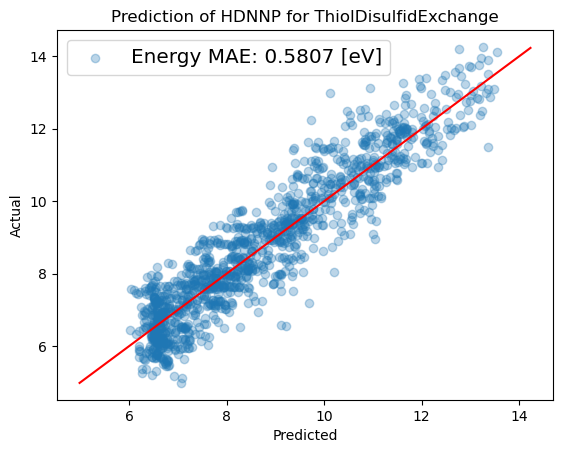

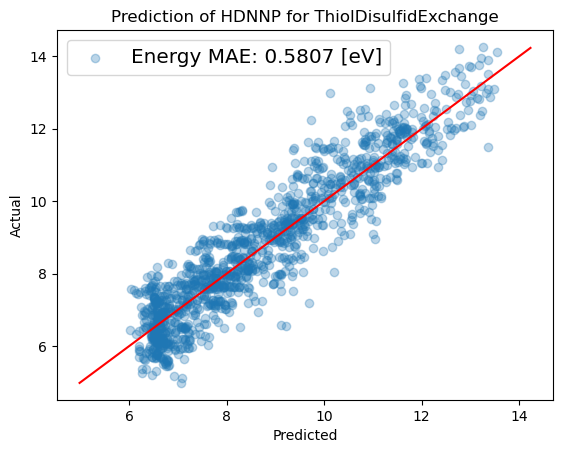

In [39]:
from kgcnn.utils.plots import plot_predict_true
plot_predict_true(predicted_y, true_y,
    filepath=data_directory, data_unit="eV",
    model_name="Mod4thGenHDNNP", dataset_name=dataset_name, target_names="Energy",
    file_name=f"predict.png")

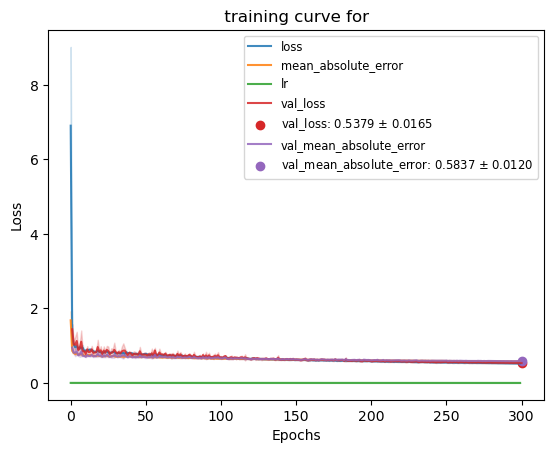

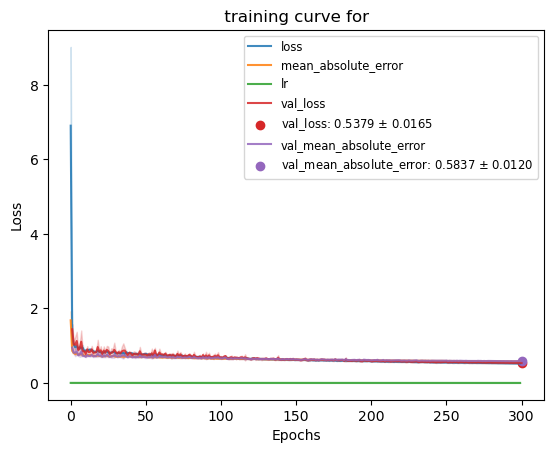

In [40]:
from kgcnn.utils.plots import plot_train_test_loss
plot_train_test_loss(hists)